In [17]:
'''
This file is for storing image data(received explicitly) 
in the database.
'''

'\nThis file is for storing image data(received explicitly) \nin the database.\n'

In [1]:
import numpy as np
import pandas as pd 
import os 

In [2]:
images = []
labels = []

In [3]:
dataset_path = './image_dataset/'
for cur in os.listdir(dataset_path):
    if cur.endswith('.ipynb_checkpoints'):
        continue
    file = pd.read_csv(dataset_path + cur)
    file = file.drop(columns = 'Unnamed: 0')
    file = file.to_numpy()
    
    images.append(file)
    labels.append(cur)    

In [93]:
'''
Idea is to concatenate image frames of all the people in a single numpy array,
but to explicitly have the knowledge of the number of frames of every person (for the purpose of labeling).
'''

'\nIdea is to concatenate image frames of all the people in a single numpy array,\nbut to explicitly have the knowledge of the number of frames of every person (for the purpose of labeling).\n'

In [4]:
ranges = []
prev = 0
for cur in images:
    ranges.append((prev,prev+cur.shape[0]))
    prev += cur.shape[0]

In [5]:
images = np.concatenate(images)

In [6]:
images.shape

(105, 40000)

In [8]:
all_images = np.resize(images,(images.shape[0],200,200))

In [9]:
ranges

[(0, 47), (47, 68), (68, 83), (83, 105)]

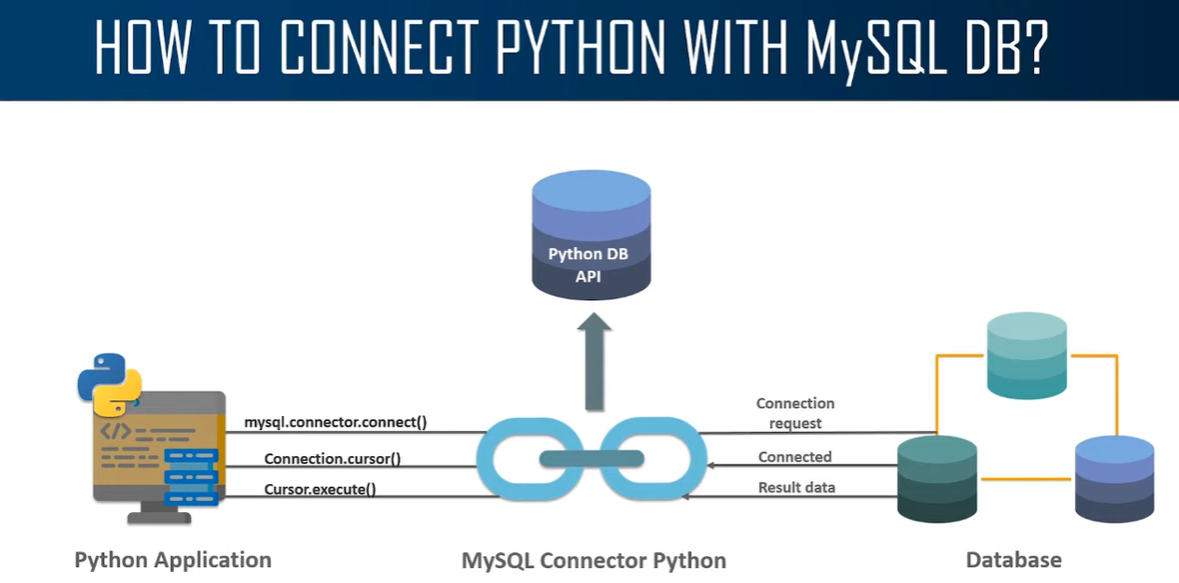

In [10]:
import mysql.connector as mc 

In [11]:
connection = mc.connect(host = 'localhost',username = 'vikranttandon',password = '2021@guruji')

In [12]:
cursor = connection.cursor(buffered=True)

In [1]:
'''

1. Why did i make buffered = True?

without a buffered cursor, the results are "lazily" loaded, 
meaning that "fetchone" actually only fetches one row from the full result set of the query.
When you will use the same cursor again, 
it will complain that you still have n-1 results (where n is the result set amount) waiting to be fetched. 
However, when you use a buffered cursor the connector fetches ALL rows behind the scenes 
and you just take one from the connector so the mysql db won't complain.

-> when buf not true, 
   There is also a possibility that your connection to MySQL Workbench is disconnected. 
   Establish the connection again. This solved the problem for me.
   

2. m_cursor only executes the operations, it doesn't return anything:

So apparently, with the mysql connector, cursor.execute(...) will return None, 
no matter what the results of executing the statements are.
However, the results WILL be stored in the cursor object itself, even if the result is an empty set. 
You must also "fetch all" results for the current query 
before using the cursor to execute new statements on the new connection as well.

'''

'\n\n1. Why did i make buffered = True?\n\nwithout a buffered cursor, the results are "lazily" loaded, \nmeaning that "fetchone" actually only fetches one row from the full result set of the query.\nWhen you will use the same cursor again, \nit will complain that you still have n-1 results (where n is the result set amount) waiting to be fetched. \nHowever, when you use a buffered cursor the connector fetches ALL rows behind the scenes \nand you just take one from the connector so the mysql db won\'t complain.\n\n-> when buf not true, \n   There is also a possibility that your connection to MySQL Workbench is disconnected. \n   Establish the connection again. This solved the problem for me.\n   \n\n2. m_cursor only executes the operations, it doesn\'t return anything:\n\nSo apparently, with the mysql connector, cursor.execute(...) will return None, \nno matter what the results of executing the statements are.\nHowever, the results WILL be stored in the cursor object itself, even if the

In [38]:
'''
Initial commands (one time commands)

m_cursor.execute('create database DATASET')
m_cursor.execute('use DATASET')

table_data = "CREATE TABLE profiles(ID INT PRIMARY KEY NOT NULL,NAME VARCHAR(50) ,images LONGBLOB);"
m_cursor.execute(table_data)
'''

'\nInitial commands (one time commands)\n\nm_cursor.execute(\'create database DATASET\')\nm_cursor.execute(\'use DATASET\')\n\ntable_data = "CREATE TABLE profiles(ID INT PRIMARY KEY,NAME VARCHAR(50) ,images LONGBLOB);"\nm_cursor.execute(table_data)\n'

In [18]:
cursor.execute('use DATASET;')

In [19]:
profile_table = 'create table if not exists profile(id bigint not null,name varchar(50),start bigint,end bigint,primary key(id));'

In [20]:
cursor.execute(profile_table)

In [21]:
image_table = 'create table if not exists image_frames(image_id bigint, image longblob);'

In [22]:
cursor.execute(image_table)

In [23]:
for idx in range(len(labels)):
    statement = ("insert into profile"
                 "(id, name, start, end)"
                 "values (%s,%s,%s,%s);")
    data = (idx,labels[idx],ranges[idx][0],ranges[idx][1])
    cursor.execute(statement,data)

In [24]:
cursor.execute('select * from profile;')

In [25]:
objects = cursor.fetchall()
objects

[(0, 'Dhruv', 0, 47),
 (1, 'Raghav', 47, 68),
 (2, 'Rishabh', 68, 83),
 (3, 'vikrant', 83, 105)]

In [26]:
for idx in range(len(all_images)):
    statement = """ insert into image_frames
                    (image_id, image)
                    values (%s,%s);
                    """
    res = all_images[idx].tobytes()
    data = (idx,res)
    cursor.execute(statement,data)

In [27]:
cursor.execute('commit ;')

In [28]:
all_images.shape

(105, 200, 200)

In [29]:
cursor.execute('select * from image_frames')

In [30]:
aux = cursor.fetchall()

In [31]:
len(aux)

105